# Predict Customer Churn -- a pyspark project

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import desc,asc,isnull,when,count,col, sum as Fsum, max as Fmax
from pyspark.sql.functions import concat, col, lit
from pyspark.sql.functions import mean
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, OneHotEncoderEstimator, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, \
                DecisionTreeClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("capstone") \
        .getOrCreate()

In [3]:
# load data
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
print("Number of rows : {}".format(df.count()))
print("Number of columns : {}".format(len(df.columns)))

Number of rows : 286500
Number of columns : 18


In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [6]:
from datetime import datetime
get_datetime=udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%m/%d/%Y, %H:%M:%S"))
df = df.withColumn("datetime",get_datetime(df.ts))

In [7]:
df.describe('ts').show()
print(datetime.fromtimestamp(1538352117000 / 1000.0).strftime("%m/%d/%Y, %H:%M:%S"))
print(datetime.fromtimestamp(1543799476000 / 1000.0).strftime("%m/%d/%Y, %H:%M:%S"))

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810471...|
| stddev|1.5075439608187113E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+

09/30/2018, 19:01:57
12/02/2018, 19:11:16


### 1. Missing Value

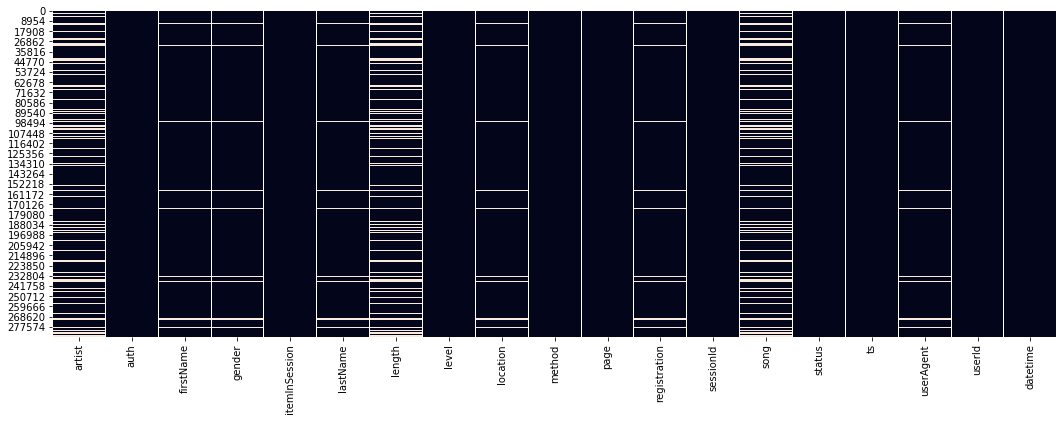

In [8]:
# Let's take a look at where the missing values are located.
plt.figure(figsize=(18,6))
sns.heatmap(df.toPandas().isnull(),cbar=False)

In [9]:
# How many missing values there are for each columns
# and how much percentage they count.
nacounts = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()
pd.concat([nacounts,nacounts.apply(lambda x:x/df.count())])

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,datetime
0,58392.000000,0.0,8346.000000,8346.000000,0.0,8346.000000,58392.000000,0.0,8346.000000,0.0,0.0,8346.000000,0.0,58392.000000,0.0,0.0,8346.000000,0.0,0.0
0,0.203812,0.0,0.029131,0.029131,0.0,0.029131,0.203812,0.0,0.029131,0.0,0.0,0.029131,0.0,0.203812,0.0,0.0,0.029131,0.0,0.0


>**Note 1:** 
   - firstname, lastname, gender, location, userAgent, and registration are missing at same rows. We can infer that these missing values come from users that are not registered. <br>
   <br>
   - Usually users who are not registered would not have a user ID; we'll explore this further. Turns out that userID column does have null values; And the number of such null values match the number of missing rows in registration.<br>
  <br>
   - Since these records do not even have userId information, we'll go ahead delete them

In [10]:
df.select('userid').filter('registration is null').show(3)
df[df.userId==""].count()
df = df[df.userId!=""]

+------+
|userid|
+------+
|      |
|      |
|      |
+------+
only showing top 3 rows



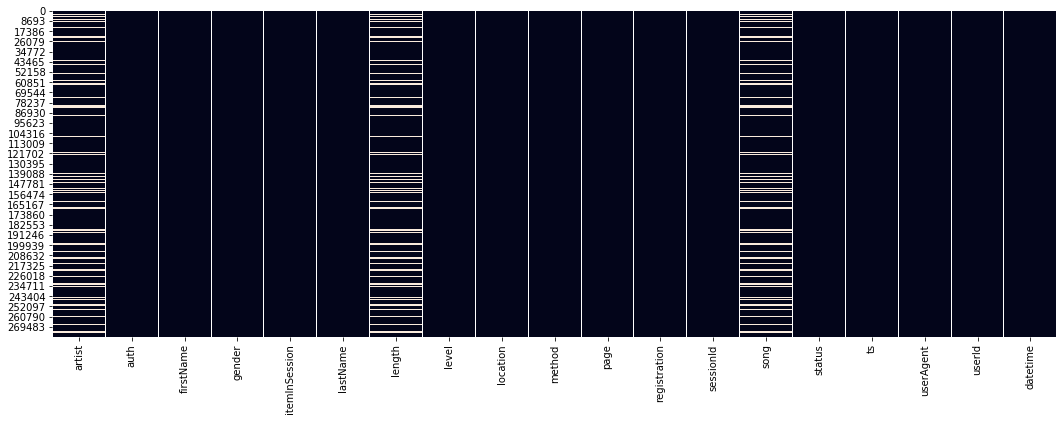

In [11]:
# show missing value figure after deleting rows that are missing 
#firstname, lastname, gender, location, userAgent, registration, and userId
df_pd = df.toPandas()
plt.figure(figsize=(18,6))
sns.heatmap(df_pd.isnull(),cbar=False)

In [12]:
nacounts = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()
pd.concat([nacounts,nacounts.apply(lambda x:x/df.count())])

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,datetime
0,50046.000000,0.0,0.0,0.0,0.0,0.0,50046.000000,0.0,0.0,0.0,0.0,0.0,0.0,50046.000000,0.0,0.0,0.0,0.0,0.0
0,0.179922,0.0,0.0,0.0,0.0,0.0,0.179922,0.0,0.0,0.0,0.0,0.0,0.0,0.179922,0.0,0.0,0.0,0.0,0.0


>**Note 2:** 
  - Artist,length,and song are missing data at the same rows.
  - These records do not have song-related information; We'll explore what pages users are on for these rows

In [13]:
print(df_pd[df_pd.artist.isnull()]['page'].value_counts())
print(df_pd[df_pd.artist.isnull()==False]['page'].value_counts())

Thumbs Up                    12551
Home                         10082
Add to Playlist               6526
Add Friend                    4277
Roll Advert                   3933
Logout                        3226
Thumbs Down                   2546
Downgrade                     2055
Settings                      1514
Help                          1454
Upgrade                        499
About                          495
Save Settings                  310
Error                          252
Submit Upgrade                 159
Submit Downgrade                63
Cancel                          52
Cancellation Confirmation       52
Name: page, dtype: int64
NextSong    228108
Name: page, dtype: int64


### 2. Feature Engineering and EDA

####  (1) Define Churned User

In [14]:
flag_cancellation = udf(lambda x : 1 if x=="Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn",flag_cancellation("page"))

In [15]:
w1 = Window.partitionBy('userId')

# Create the cross-sectional dataframe that we'll use in analysis and modelling
df_user = df.select('userId','churn','gender','level') \
            .withColumn('churned_user',Fsum('churn').over(w1)) \
            .dropDuplicates(['userId']).drop('churn')

df_user.groupby('churned_user')\
        .count().show()

+------------+-----+
|churned_user|count|
+------------+-----+
|           0|  173|
|           1|   52|
+------------+-----+



In [16]:
df_user.show(2)

+------+------+-----+------------+
|userId|gender|level|churned_user|
+------+------+-----+------------+
|100010|     F| free|           0|
|200002|     M| free|           0|
+------+------+-----+------------+
only showing top 2 rows



#### (2) Categorical Features

In [17]:
# convert categorical features to label encoding
indexer = StringIndexer(inputCol="gender",outputCol="genderIndex")
df_user = indexer.fit(df_user).transform(df_user)
indexer = StringIndexer(inputCol="level",outputCol="levelIndex")
df_user = indexer.fit(df_user).transform(df_user)

In [18]:
df_user.show(3)

+------+------+-----+------------+-----------+----------+
|userId|gender|level|churned_user|genderIndex|levelIndex|
+------+------+-----+------------+-----------+----------+
|100010|     F| free|           0|        1.0|       0.0|
|200002|     M| free|           0|        0.0|       0.0|
|   125|     M| free|           1|        0.0|       0.0|
+------+------+-----+------------+-----------+----------+
only showing top 3 rows



In [19]:
df_user.groupby('genderIndex').avg('churned_user').show()

+-----------+-------------------+
|genderIndex|  avg(churned_user)|
+-----------+-------------------+
|        0.0| 0.2644628099173554|
|        1.0|0.19230769230769232|
+-----------+-------------------+



In [20]:
df_user.groupby('churned_user').avg('levelIndex').show()

+------------+-------------------+
|churned_user|    avg(levelIndex)|
+------------+-------------------+
|           0|0.23121387283236994|
|           1|0.15384615384615385|
+------------+-------------------+



In [21]:
# convert label encoding to dummy variables
encoder = OneHotEncoderEstimator(inputCols=["genderIndex", "levelIndex"],
                                 outputCols=["genderVector", "levelVector"])
model = encoder.fit(df_user)
df_user = model.transform(df_user)

In [22]:
df_user.select('userId','genderVector','levelVector').show(3)

+------+-------------+-------------+
|userId| genderVector|  levelVector|
+------+-------------+-------------+
|100010|    (1,[],[])|(1,[0],[1.0])|
|200002|(1,[0],[1.0])|(1,[0],[1.0])|
|   125|(1,[0],[1.0])|(1,[0],[1.0])|
+------+-------------+-------------+
only showing top 3 rows



#### (2)  General activitiy aggregates

In [23]:
df_numSessions = df.select('userId','sessionId')\
                .dropDuplicates(['sessionId','userId'])\
                .withColumn('numSessions',count(df.userId).over(w1))\
                .dropDuplicates(['userId'])\
                .drop('sessionId')

In [24]:
df_numSongs = df.select('userId','song')\
                .dropDuplicates(['userId','song'])\
                .withColumn('numSongs',count(df.userId).over(w1))\
                .dropDuplicates(['userId'])\
                .drop('song')

In [25]:
df_numArtists = df.select('userId','artist')\
                .dropDuplicates(['userId','artist'])\
                .withColumn('numArtists',count(df.userId).over(w1))\
                .dropDuplicates(['userId'])\
                .drop('artist')

In [26]:
df_playTime = df.filter(df['page']=='NextSong')\
            .select('userId','length')\
            .withColumn('playTime',Fsum('length').over(w1))\
            .dropDuplicates(['userId'])\
            .drop('song')

In [27]:
df_activeDays = df.select('userId','ts','registration')\
    .withColumn('mostRecentTs',Fmax('ts').over(w1))\
    .dropDuplicates(['userId'])\
    .withColumn("activeDays",(col('ts')/1000.-col('registration')/1000.)/86400.)\
    .drop('registration')

In [28]:
# Add these feature to the df_user dataframe
df_user = df_user.join(df_numSessions,df_user.userId==df_numSessions.userId).select(df_user["*"],df_numSessions['numSessions'])
df_user = df_user.join(df_numSongs,df_user.userId==df_numSongs.userId).select(df_user["*"],df_numSongs['numSongs'])
df_user = df_user.join(df_numArtists,df_user.userId==df_numArtists.userId).select(df_user["*"],df_numArtists['numArtists'])
df_user = df_user.join(df_playTime,df_user.userId==df_playTime.userId).select(df_user["*"],df_playTime['playTime'])
df_user = df_user.join(df_activeDays,df_user.userId==df_activeDays.userId).select(df_user["*"],df_activeDays['activeDays'])

In [29]:
df_user.show(2)

+------+------+-----+------------+-----------+----------+-------------+-------------+-----------+--------+----------+-----------------+------------------+
|userId|gender|level|churned_user|genderIndex|levelIndex| genderVector|  levelVector|numSessions|numSongs|numArtists|         playTime|        activeDays|
+------+------+-----+------------+-----------+----------+-------------+-------------+-----------+--------+----------+-----------------+------------------+
|100010|     F| free|           0|        1.0|       0.0|    (1,[],[])|(1,[0],[1.0])|          7|     270|       253|66940.89735000003|11.425856481481482|
|200002|     M| free|           0|        0.0|       0.0|(1,[0],[1.0])|(1,[0],[1.0])|          6|     379|       340|94008.87593999993|24.577824074074073|
+------+------+-----+------------+-----------+----------+-------------+-------------+-----------+--------+----------+-----------------+------------------+
only showing top 2 rows



In [30]:
temp = df_user.toPandas()
temp[['numSessions','numSongs','numArtists','playTime','activeDays','genderIndex','levelIndex']].corr()

,numSessions,numSongs,numArtists,playTime,activeDays,genderIndex,levelIndex
numSessions,1.000000,0.885881,0.862177,0.896533,-0.048010,0.180542,0.021865
numSongs,0.885881,1.000000,0.993745,0.997056,-0.027022,0.170745,0.118877
numArtists,0.862177,0.993745,1.000000,0.982672,-0.038602,0.168952,0.134793
playTime,0.896533,0.997056,0.982672,1.000000,-0.020201,0.170771,0.107622
activeDays,-0.048010,-0.027022,-0.038602,-0.020201,1.000000,0.023135,-0.011479
genderIndex,0.180542,0.170745,0.168952,0.170771,0.023135,1.000000,0.104740
levelIndex,0.021865,0.118877,0.134793,0.107622,-0.011479,0.104740,1.000000


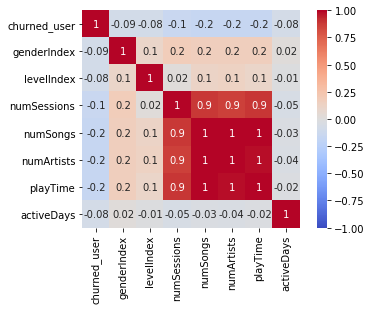

In [31]:
sns.heatmap(temp.corr(),annot=True,fmt='.1g',vmin=-1,vmax=1,center=0,cmap='coolwarm',square=True)

#### (3) Page visits aggregates

In [32]:
#generate page visit aggreates features
w2 = Window.partitionBy('userId','page')
columns = [str(row.page) for row in df.select('page')\
           .dropDuplicates().sort('page').collect()]
df_pageVisits = df.select('userId','page')\
    .withColumn('pageVisits',count('userId').over(w2))\
    .groupby('userId')\
    .pivot('page',columns)\
    .mean('pageVisits')
df_pageVisits = df_pageVisits.na.fill(0).drop('Cancel','Cancellation Confirmation')

In [33]:
# joining the page visits features with the cross sectional dataframe of users
df_inuse = df_pageVisits.join(df_user,df_pageVisits.userId==df_user.userId)\
.select(df_user.churned_user,df_pageVisits['*'],df_user.numSessions,df_user.numSongs,\
        df_user.numArtists, df_user.playTime,df_user.activeDays,df_user.genderIndex,\
        df_user.levelIndex,df_user.genderVector,df_user.levelVector)

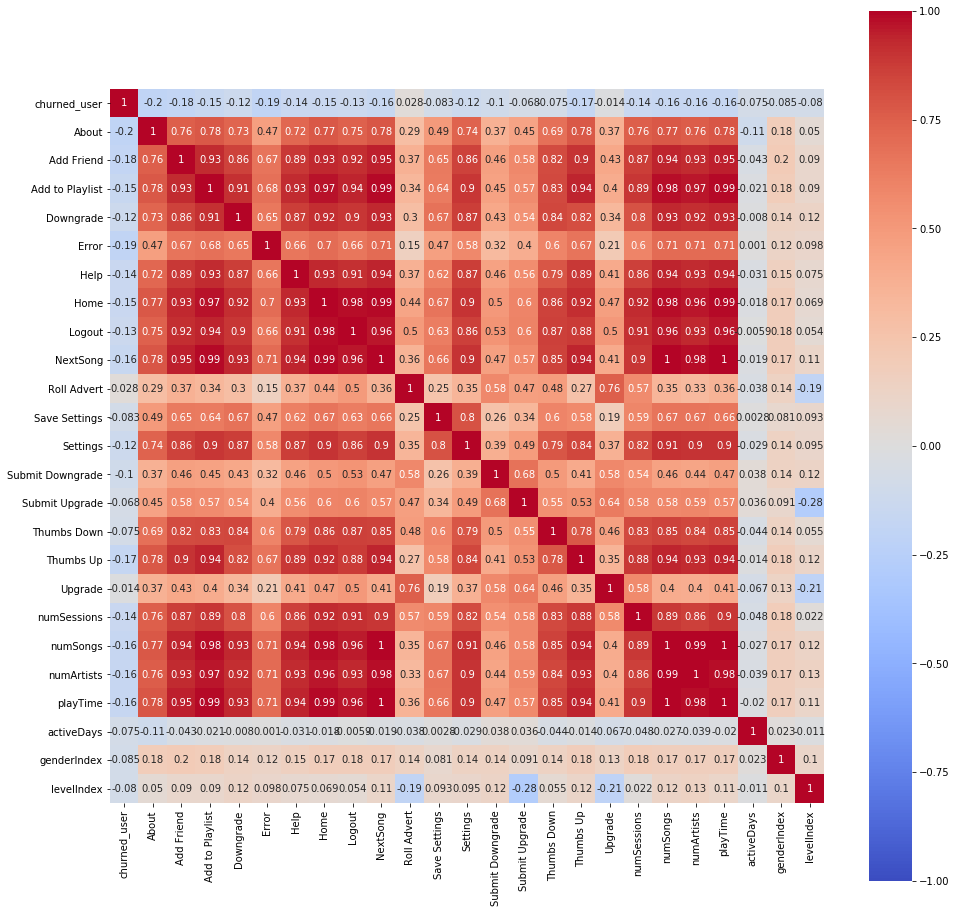

In [34]:
plt.figure(figsize = (16,16))
sns.heatmap(df_inuse.toPandas().corr(),annot=True,fmt='.2g'\
            ,vmin=-1,vmax=1,center=0,cmap='coolwarm',square=True)

In [35]:
# Drop features that have correlation with each up
df_inuse= df_inuse.drop('Add Friend','Add to Playlist', 'Downgrade','Help','Home',\
                          'Logout','NextSong','Settings','Thumbs Up','Thumbs down','numSongs','numArtists',
                       'playTime')

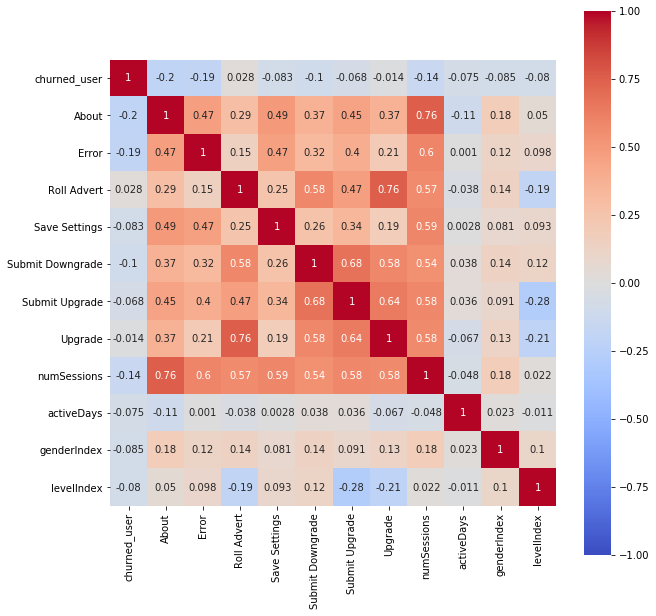

In [36]:
plt.figure(figsize = (10,10))
sns.heatmap(df_inuse.toPandas().corr(),annot=True,fmt='.2g'\
            ,vmin=-1,vmax=1,center=0,cmap='coolwarm',square=True)

In [37]:
df_inuse.take(2)

[Row(churned_user=0, userId='100010', About=1.0, Error=0.0, Roll Advert=52.0, Save Settings=0.0, Submit Downgrade=0.0, Submit Upgrade=0.0, Upgrade=2.0, numSessions=7, activeDays=11.425856481481482, genderIndex=1.0, levelIndex=0.0, genderVector=SparseVector(1, {}), levelVector=SparseVector(1, {0: 1.0})),
 Row(churned_user=0, userId='200002', About=3.0, Error=0.0, Roll Advert=7.0, Save Settings=0.0, Submit Downgrade=0.0, Submit Upgrade=1.0, Upgrade=2.0, numSessions=6, activeDays=24.577824074074073, genderIndex=0.0, levelIndex=0.0, genderVector=SparseVector(1, {0: 1.0}), levelVector=SparseVector(1, {0: 1.0}))]

### 3. Feature Scaling

In [38]:
# Vector Assembler
cols = df_inuse.drop('userID','churned_user').columns
assembler = VectorAssembler(inputCols=cols,outputCol='feature_vector')
df_inuse = assembler.transform(df_inuse).select('userId','churned_user','feature_vector')

In [39]:
df_inuse.take(1)

[Row(userId='100010', churned_user=0, feature_vector=SparseVector(13, {0: 1.0, 2: 52.0, 6: 2.0, 7: 7.0, 8: 11.4259, 9: 1.0, 12: 1.0}))]

In [40]:
# Standard Scaler
scaler = StandardScaler(inputCol='feature_vector',
                       outputCol ='features',
                       withStd=True)
scalerModel = scaler.fit(df_inuse)
df_inuse_scaled = scalerModel.transform(df_inuse)

In [41]:
df_inuse_scaled.take(1)

[Row(userId='100010', churned_user=0, feature_vector=SparseVector(13, {0: 1.0, 2: 52.0, 6: 2.0, 7: 7.0, 8: 11.4259, 9: 1.0, 12: 1.0}), features=SparseVector(13, {0: 0.3205, 2: 2.413, 6: 0.7817, 7: 0.4779, 8: 0.3488, 9: 2.0013, 12: 2.4356}))]

In [42]:
df_inuse_scaled = df_inuse_scaled.withColumnRenamed("churned_user", "label")

### 4. Modelling

In [43]:
# prepare training and test data, sample by label
ratio = 0.8
train = df_inuse_scaled.sampleBy('label',fractions = {0:ratio,1:ratio},
                                  seed = 24)
test = df_inuse_scaled.subtract(train)

In [44]:
def evaluate(model_name,train,test):
    """Function to train, fit, and evaluate classification models
    Input: model_name(Spark ML model instance)
            train: training set
            test: test set
    Output:
        cross validation f1 score, test set f1 score
    """
    evaluator = MulticlassClassificationEvaluator(metricName='f1')
    paramGrid = ParamGridBuilder().build()
    crossval = CrossValidator(estimator=model_name,
                          evaluator=evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)
    cvModel = crossval.fit(train)
    cvModel_metrics = cvModel.avgMetrics
    transformed_data=cvModel.transform(test)
    test_metrics = evaluator.evaluate(transformed_data)
    return (cvModel_metrics, test_metrics)

In [45]:
lr = LogisticRegression()
svc = LinearSVC()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbt = GBTClassifier()

In [46]:
model_names = [lr,svc,dtc,rfc,gbt]

In [47]:
for model in model_names:
    a = evaluate(model,train,test)
    print(model,a)

LogisticRegression_2332a112b60e ([0.6748070616648503], 0.6634482758620689)
LinearSVC_40edd9ac54b4 ([0.6650762230383898], 0.6835955056179777)
DecisionTreeClassifier_aba9788facfb ([0.7178099171137258], 0.6133574442435202)
RandomForestClassifier_94dcc8bbe114 ([0.7171704804465001], 0.6634482758620689)
GBTClassifier_8586ab00b7b2 ([0.7511275108554512], 0.6000000000000001)
